In [72]:
import torch
import torch.nn as nn

import time

import numpy as np
import matplotlib.pyplot as plt

## Load data

In [49]:
data_path = '../'
full_data = torch.load(data_path + 'unaug_data_small.pt')
full_label = torch.load(data_path + 'unaug_label.pt')

full_size = full_data.size(0)


In [50]:
# TODO: split into training and testing 80%-20%
indices = torch.randperm(full_size)
train_size = int(full_size * 0.8)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = full_data[train_indices]
train_label = full_label[train_indices]
test_data = full_data[test_indices]
test_label = full_label[test_indices]

In [51]:
train_data = train_data / 255
test_data = test_data / 255

In [52]:
# show size
print("Training data, ", train_data.size())
print("Training label,", train_label.size())


Training data,  torch.Size([4889, 3, 32, 32])
Training label, torch.Size([4889])


In [53]:
train_data_size = train_data.size(0)
print(train_data_size)
print(train_data.is_contiguous())

4889
True


## Utility Functions
- display num param
- show image

- get error
- evaluate on test data

In [39]:
# Util func
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [75]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')


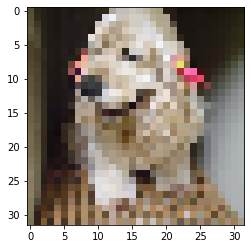

In [74]:
show(train_data[100])

In [40]:
def get_error( scores , labels ):
    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

In [54]:
def eval_on_test_set():
    test_size = test_data.size(0)

    running_error=0
    num_batches=0

    for i in range(0,(test_size//bs)*bs,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        inputs = minibatch_data.view(bs,3072)

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

## Build MLP
A 3-layer MLP

In [55]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, output_size)   
        
    def forward(self, x):
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

In [76]:
net=three_layer_net(3072,500,500,10)
print(net)
display_num_param(net)

three_layer_net(
  (layer1): Linear(in_features=3072, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=10, bias=True)
)
There are 1792010 (1.79 million) parameters in this neural network


## Define Hyper-parameters

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.03 )
bs= 50

## Training

In [80]:
start=time.time()

for epoch in range(10):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_data_size)
 
    for count in range(0, (train_data_size//bs)*bs ,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # reshape the minibatch
        inputs = minibatch_data.view(bs,3072)  # to continuous tensor

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%1 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')
    
    
        
        

epoch= 0 	 time= 1.0279300212860107 	 loss= 2.1665711501210008 	 error= 80.02061874596113 percent
test error  =  79.24999967217445 percent
 
epoch= 1 	 time= 2.083064079284668 	 loss= 2.150948321696409 	 error= 78.14433015498918 percent
test error  =  80.33333321412405 percent
 
epoch= 2 	 time= 3.130244016647339 	 loss= 2.13598174409768 	 error= 77.56701056490239 percent
test error  =  77.83333336313567 percent
 
epoch= 3 	 time= 4.178261995315552 	 loss= 2.124136321323434 	 error= 77.34020604300744 percent
test error  =  79.24999942382178 percent
 
epoch= 4 	 time= 5.226637125015259 	 loss= 2.109567149398253 	 error= 76.63917535359097 percent
test error  =  76.58333306511244 percent
 
epoch= 5 	 time= 6.360378742218018 	 loss= 2.098956754527141 	 error= 75.29896921718243 percent
test error  =  76.75000031789145 percent
 
epoch= 6 	 time= 7.475813865661621 	 loss= 2.0854388807237765 	 error= 75.42268013216786 percent
test error  =  77.50000034769377 percent
 
epoch= 7 	 time= 8.533814